In [1]:
import pandas as pd
from collections import Counter
from datasets import Dataset

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
def load_data(file_path, col_name=None):
    return pd.read_csv(file_path, sep=r'\n', header=None, names=[col_name], engine='python')

noisy_train_df = load_data('data/gtc/train.tok.fr.txt', 'noisy_text')
noisy_test_df = load_data('data/gtc/dev.tok.fr.txt', 'noisy_text')

clean_train_df = load_data('data/gtc/train.tok.en.txt', 'clean_text')
clean_test_df = load_data('data/gtc/dev.tok.en.txt', 'clean_text')

                                          noisy_text
0  I n s t a l l ▁ B o c l o u d ▁ B e y o n d C ...
1  # # ▁ i s t a n b u l ▁ i g n o r e ▁ n e x t ...
2  # # ▁ v a r i a b l e s ▁ t o ▁ c a l c u r a ...
3  # ▁ o f ▁ t h e ▁ b e a n ▁ w h i c h ▁ t h ▁ ...
4  A s ▁ m y ▁ O S S ▁ t i m e ▁ b u d g e d ▁ i ...
5  # h 4 # S a n ▁ L o u i s ▁ O b i s p o , ▁ C ...
6  # # ▁ M a n a g e m e n t G r o u p I d s ▁ - ...
7  # p # Y o u r ▁ S S L ▁ c o n f i g u r a t i ...
8  h t t p # # # m i r r o r - 1 . t r u e n e t ...
9  # # ▁ M a k e ▁ H O M E - v a r i a b l e ▁ c ...
Number of rows: 60576

Most common tokens:
Token: ' t h e ', Frequency: 44268
Token: ' t o ', Frequency: 25849
Token: ' a ', Frequency: 19234
Token: ' a n d ', Frequency: 15136
Token: ' o f ', Frequency: 14561
Token: ' i s ', Frequency: 14140
Token: '# ', Frequency: 10897
Token: ' i n ', Frequency: 10485
Token: ' f o r ', Frequency: 9419
Token: ' b e ', Frequency: 7746

             lenght      word_cnt      hash_

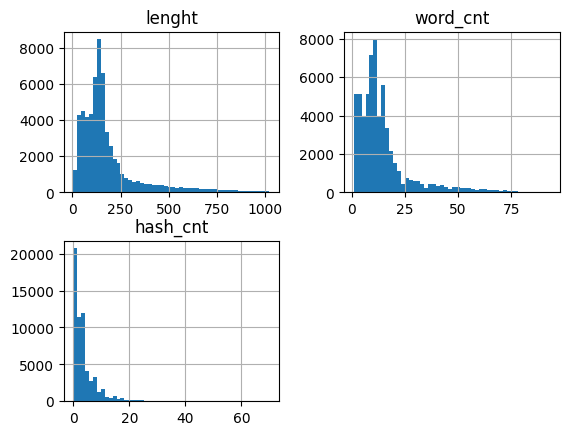

In [3]:
def explore_data(df):
    # Display a sample of 10 rows from the DataFrame
    print(df.sample(10, random_state=42).reset_index(drop=True))
    print(f"Number of rows: {len(df)}")

    # Display top 10 most common tokens
    col = df.columns[0]
    tok_freq = Counter(tok for row in df[col] for tok in row.split('▁'))
    print("\nMost common tokens:")
    for tok, freq in tok_freq.most_common(10):
        print(f"Token: '{tok}', Frequency: {freq}")

    stats = pd.DataFrame()
    stats['lenght'] = df[col].str.len()
    stats['word_cnt'] = df[col].str.split('▁').apply(len)
    stats['hash_cnt'] = df[col].str.count('#')

    print(f"\n{stats.describe()}")
    stats.hist(bins=50)

subset_size = int(len(noisy_train_df) // 4)
noisy_train_df = noisy_train_df.iloc[:subset_size]
clean_train_df = clean_train_df.iloc[:subset_size]
explore_data(noisy_train_df)

                                          clean_text
0  # - # r e a l l y ▁ m e s s e d ▁ u p ▁ s c r ...
1  b e ▁ c o n s i d e r e d ▁ e x p e r i m e n ...
2  I f ▁ y o u ▁ a r e ▁ u s i n g ▁ G i t b u c ...
3  t h e ▁ b e s t ▁ w a y ▁ t o ▁ d o ▁ t h a t ...
4  I t ▁ t a k e s ▁ a n ▁ a r r a y ▁ a n d ▁ c ...
5          p u s h b u l l e t a l e r t # # o f f #
6  T h i s ▁ t o o l ▁ i m p l e m e n t s ▁ i d ...
7  H o w e v e r , ▁ i n ▁ a ▁ m i c r o s e r v ...
8  # # ▁ i t ▁ m u s t n t ▁ b r e a k ▁ i f ▁ t ...
9  # ▁ t h e ▁ n o t i f i c a t i o n ▁ # u s e ...
Number of rows: 12752

Most common tokens:
Token: ' t h e ', Frequency: 9272
Token: ' t o ', Frequency: 5418
Token: ' a ', Frequency: 4054
Token: ' a n d ', Frequency: 3183
Token: ' o f ', Frequency: 3134
Token: ' i s ', Frequency: 2973
Token: '# ', Frequency: 2232
Token: ' i n ', Frequency: 2201
Token: ' f o r ', Frequency: 1977
Token: ' b e ', Frequency: 1694

             lenght      word_cnt      hash_cnt
coun

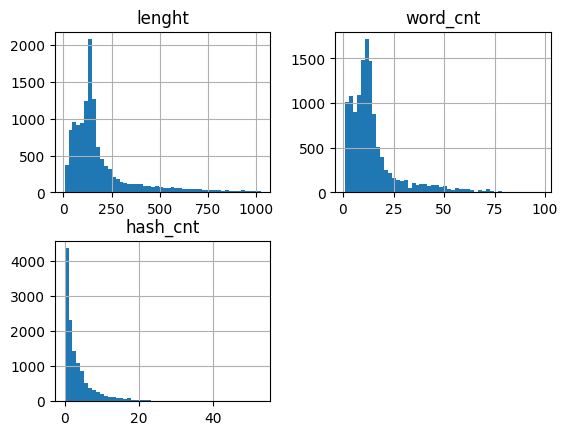

In [4]:
explore_data(clean_test_df)

In [5]:
tokenizer = Tokenizer(filters='', split='▁', oov_token='<unk>', lower=False)
tokenizer.fit_on_texts(
    noisy_train_df['noisy_text'].tolist() +
    clean_train_df['clean_text'].tolist()
)

start_token = '<start>'
end_token = '<end>'

tokenizer.word_index[start_token] = len(tokenizer.word_index) + 1
tokenizer.word_index[end_token] = len(tokenizer.word_index) + 1

vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 129013


In [6]:
def encode_texts(texts, add_start_end=True):
    seqs = tokenizer.texts_to_sequences(texts)
    if not add_start_end:
        return seqs
    out = []
    for s in seqs:
        out.append([tokenizer.word_index[start_token]] + s + [tokenizer.word_index[end_token]])
    return out

train_src_seqs = encode_texts(noisy_train_df['noisy_text'], add_start_end=False)
train_tgt_seqs = encode_texts(clean_train_df['clean_text'], add_start_end=True)

test_src_seqs  = encode_texts(noisy_test_df['noisy_text'],  add_start_end=False)
test_tgt_seqs  = encode_texts(clean_test_df['clean_text'],  add_start_end=True)

In [7]:
MAX_SEQ_LEN = 60

train_src = pad_sequences(train_src_seqs, maxlen=MAX_SEQ_LEN, padding='post')
train_tgt = pad_sequences(train_tgt_seqs, maxlen=MAX_SEQ_LEN, padding='post')
test_src = pad_sequences(test_src_seqs,  maxlen=MAX_SEQ_LEN, padding='post')
test_tgt = pad_sequences(test_tgt_seqs,  maxlen=MAX_SEQ_LEN, padding='post')

train_dec_in  = train_tgt[:, :-1]
train_dec_out = train_tgt[:, 1:]
test_dec_in   = test_tgt[:, :-1]
test_dec_out  = test_tgt[:, 1:]

In [8]:
BATCH_SIZE = 64
BUFFER_SIZE = len(train_src)

train_dataset = tf.data.Dataset.from_tensor_slices(
    ((train_src, train_dec_in), train_dec_out)
).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices(
    ((test_src, test_dec_in), test_dec_out)
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [9]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb   = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
    def call(self, x):
        seq_len = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=seq_len, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [10]:
class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attn = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(d_ff, activation="relu"),
            tf.keras.layers.Dense(d_model),
        ])
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.drop1 = tf.keras.layers.Dropout(dropout)
        self.drop2 = tf.keras.layers.Dropout(dropout)

    def call(self, x, training):
        # self-attention
        attn_out = self.attn(x, x)
        attn_out = self.drop1(attn_out, training=training)
        x1 = self.norm1(x + attn_out)
        # feed-forward
        ffn_out = self.ffn(x1)
        ffn_out = self.drop2(ffn_out, training=training)
        return self.norm2(x1 + ffn_out)

In [11]:
class DecoderBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.cross_attn = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(d_ff, activation="relu"),
            tf.keras.layers.Dense(d_model),
        ])
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.drop1 = tf.keras.layers.Dropout(dropout)
        self.drop2 = tf.keras.layers.Dropout(dropout)
        self.drop3 = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_output, training, look_ahead_mask=None):
        # 1) masked self-attention
        att1 = self.self_attn(x, x, attention_mask=look_ahead_mask)
        att1 = self.drop1(att1, training=training)
        x1 = self.norm1(x + att1)

        # 2) cross-attention to encoder output
        att2 = self.cross_attn(x1, enc_output)
        att2 = self.drop2(att2, training=training)
        x2 = self.norm2(x1 + att2)

        # 3) feed-forward
        ffn_out = self.ffn(x2)
        ffn_out = self.drop3(ffn_out, training=training)
        return self.norm3(x2 + ffn_out)

In [12]:
def create_look_ahead_mask(seq_len):
    return 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)

def build_seq2seq_transformer(src_vocab_size,tgt_vocab_size,max_seq_len,
    d_model=32, num_heads=2, d_ff=128, num_layers=1, dropout=0.1):

    src_inputs = tf.keras.Input(shape=(max_seq_len,), name="source")
    tgt_inputs = tf.keras.Input(shape=(max_seq_len-1,), name="target")

    # Embeddings
    src_emb = TokenAndPositionEmbedding(max_seq_len, src_vocab_size, d_model)(src_inputs)
    tgt_emb = TokenAndPositionEmbedding(max_seq_len-1, tgt_vocab_size, d_model)(tgt_inputs)

    # Encoder stack
    x = src_emb
    for _ in range(num_layers):
        x = EncoderBlock(d_model, num_heads, d_ff, dropout)(x, training=True)
    enc_output = x  # (batch, src_len, d_model)

    # Prepare look-ahead mask for decoder
    look_ahead = create_look_ahead_mask(max_seq_len-1)
    # expand dims to [batch, heads, tgt_len, tgt_len] when called in block

    # Decoder stack
    y = tgt_emb
    for _ in range(num_layers):
        y = DecoderBlock(d_model, num_heads, d_ff, dropout)(
                y,
                enc_output,
                training=True,
                look_ahead_mask=tf.expand_dims(tf.expand_dims(look_ahead, 0), 1)
            )

    # Final linear + softmax projection
    outputs = tf.keras.layers.Dense(tgt_vocab_size, activation="softmax")(y)

    return tf.keras.Model(inputs=[src_inputs, tgt_inputs], outputs=outputs)

In [13]:
model = build_seq2seq_transformer(
    src_vocab_size=vocab_size,
    tgt_vocab_size=vocab_size,
    max_seq_len=MAX_SEQ_LEN,
)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ source (InputLayer) │ (None, 60)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target (InputLayer) │ (None, 59)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, 60, 32)    │  4,130,336 │ source[0][0]      │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, 59, 32)    │  4,130,304 │ target[0][0]      │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_block       │ (None, 60, 32)    │     16,896 │ token_and_positi… │
│ (EncoderBlock)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_block       │ (None, 59, 32)    │     25,376 │ token_and_positi… │
│ (DecoderBlock)      │                   │            │ encoder_block[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 59,        │  4,257,429 │ decoder_block[0]… │
│                     │ 129013)           │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,560,341 (47.91 MB)

 Trainable params: 12,560,341 (47.91 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    verbose=1
)

Epoch 1/10
947/947 ━━━━━━━━━━━━━━━━━━━━ 1608s 2s/step - accuracy: 0.7453 - loss: 4.7317 - val_accuracy: 0.8272 - val_loss: 1.4710
Epoch 2/10
947/947 ━━━━━━━━━━━━━━━━━━━━ 1639s 2s/step - accuracy: 0.8515 - loss: 1.2447 - val_accuracy: 0.9006 - val_loss: 0.9256
Epoch 3/10
947/947 ━━━━━━━━━━━━━━━━━━━━ 1673s 2s/step - accuracy: 0.9101 - loss: 0.7873 - val_accuracy: 0.9318 - val_loss: 0.7023
Epoch 4/10
947/947 ━━━━━━━━━━━━━━━━━━━━ 1636s 2s/step - accuracy: 0.9394 - loss: 0.5366 - val_accuracy: 0.9477 - val_loss: 0.5846
Epoch 5/10
947/947 ━━━━━━━━━━━━━━━━━━━━ 1636s 2s/step - accuracy: 0.9560 - loss: 0.3761 - val_accuracy: 0.9568 - val_loss: 0.5329
Epoch 6/10
947/947 ━━━━━━━━━━━━━━━━━━━━ 1636s 2s/step - accuracy: 0.9676 - loss: 0.2609 - val_accuracy: 0.9618 - val_loss: 0.5108
Epoch 7/10
947/947 ━━━━━━━━━━━━━━━━━━━━ 1659s 2s/step - accuracy: 0.9760 - loss: 0.1807 - val_accuracy: 0.9649 - val_loss: 0.5086
Epoch 8/10
947/947 ━━━━━━━━━━━━━━━━━━━━ 1634s 2s/step - accuracy: 0.9829 - loss: 0.1187 - 

In [17]:
eval_loss, eval_acc = model.evaluate(val_dataset)

200/200 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - accuracy: 0.9721 - loss: 0.5340


In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, target_metric):
    title = target_metric[0].upper() + target_metric[1:]
    plt.figure(figsize=(10, 6))
    plt.plot(history.history[target_metric], label=f'Train {title}')
    plt.plot(history.history[f'val_{target_metric}'], label=f'Test {title}')
    plt.xlabel('Epochs')
    plt.ylabel(title)
    plt.title(f'{title} Trajectory')
    plt.legend()
    plt.show()

plot_history(history, 'accuracy')
plot_history(history, 'loss')  

In [ ]:
sample_idx = 0
src_sample = test_src[sample_idx:sample_idx+1]
dec_in_sample= test_dec_in[sample_idx:sample_idx+1]
true_token = test_dec_out[sample_idx, 0]

base_pred = model.predict([src_sample, dec_in_sample])[0, 0, true_token]

occlusion_scores = []
for pos in range(MAX_SEQ_LEN):
    masked = src_sample.copy()
    masked[0, pos] = tokenizer.word_index['<unk>']
    pred = model.predict([masked, dec_in_sample])[0, 0, true_token]
    occlusion_scores.append(float(base_pred - pred))

plt.figure(figsize=(10, 6))
plt.bar(range(MAX_SEQ_LEN), occlusion_scores)
plt.title("Occlusion importance (Prob of true token)")
plt.xlabel("Token position")
plt.ylabel("Probability")
plt.show()